<a href="https://colab.research.google.com/github/camondino/Meli-IAM-Challenge/blob/main/Challenge__v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerias


Instalo las librerías necesarias

In [1]:
!pip3 install matplotlib -q

In [3]:
!pip install ydata-profiling -q

In [60]:
# Procesamiento
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder

# Modelos
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score

## EDA

Abrimos el archivo csv con Pandas y analizamos un poco las columnas para ver el tipo de cada atributo y si tienen valores nan

In [6]:
path = '/content/datasetChallangeMeLi.csv'
df = pd.read_csv(path, engine='python', encoding_errors='replace', on_bad_lines='warn') # Si queremos leer menos lineas usamos: nrows=300000 
df.head()

Skipping line 84503: unexpected end of data


timestamp  processId  parentProcessId  userId      processName  \
0  124.440464        387                1     101  systemd-resolve   
1  124.441004          1                0       0          systemd   
2  124.441045          1                0       0          systemd   
3  124.441073          1                0       0          systemd   
4  124.441202          1                0       0          systemd   

         hostName  eventId           eventName  argsNum  returnValue  \
0  ip-10-100-1-26       41              socket        3           15   
1  ip-10-100-1-26     1005  security_file_open        4            0   
2  ip-10-100-1-26      257              openat        4           12   
3  ip-10-100-1-26        5               fstat        2            0   
4  ip-10-100-1-26        3               close        1            0   

                                                args  sus  evil  
0  [{'name': 'domain', 'type': 'int', 'value': 'A...    0     0  
1  [{'name': 'pathname', 'type': 'const char*', '...    0     0  
2  [{'name': 'dirfd', 'type': 'int', 'value': -10...    0     0  
3  [{'name': 'fd', 'type': 'int', 'value': 12}, {...    0     0  
4       [{'name': 'fd', 'type': 'int', 'value': 12}]    0     0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84501 entries, 0 to 84500
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        84501 non-null  float64
 1   processId        84501 non-null  int64  
 2   parentProcessId  84501 non-null  int64  
 3   userId           84501 non-null  int64  
 4   processName      84501 non-null  object 
 5   hostName         84501 non-null  object 
 6   eventId          84501 non-null  int64  
 7   eventName        84501 non-null  object 
 8   argsNum          84501 non-null  int64  
 9   returnValue      84501 non-null  int64  
 10  args             84501 non-null  object 
 11  sus              84501 non-null  int64  
 12  evil             84501 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 8.4+ MB


In [8]:
df.describe()

timestamp     processId  parentProcessId        userId  \
count  84501.000000  84501.000000     84501.000000  84501.000000   
mean    2003.283889   6777.106863      2606.297795      7.696560   
std     1201.834845   1945.973368      2490.360229     82.224878   
min      124.440464      1.000000         0.000000      0.000000   
25%      914.942358   7332.000000      1567.000000      0.000000   
50%     1983.537746   7368.000000      1570.000000      0.000000   
75%     3025.184337   7393.000000      1570.000000      0.000000   
max     4127.970425   7418.000000      7321.000000   1000.000000   

            eventId       argsNum   returnValue           sus     evil  
count  84501.000000  84501.000000  84501.000000  84501.000000  84501.0  
mean     360.171738      2.838191     13.941646      0.035940      0.0  
std      416.947404      1.361458    263.153207      0.186143      0.0  
min        3.000000      0.000000   -115.000000      0.000000      0.0  
25%        3.000000      1.000000      0.000000      0.000000      0.0  
50%      257.000000      4.000000      0.000000      0.000000      0.0  
75%     1005.000000      4.000000      4.000000      0.000000      0.0  
max     1010.000000      5.000000   7418.000000      1.000000      0.0

Vamos a realizar el EDA de todo el dataset

In [9]:
profile = ProfileReport(df, title="EDA")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Viendo el resultado del EDA, podemos sacar multiples conclusiones de las variables. Algunos atributos: 

* Aportan la misma información como processId & processName y eventId & eventName
* No aportan información ya que son siempre constantes como hostName, sus y evil
* El 98.9% de los registros de userId son 0
* La relación entre processId y processName no es 1:1
* La gran mayoria de las variables son categoricas




Verificamos que la relacion entre processId y processName no es 1:1


In [10]:
l = np.unique(df['processId'])

# Por id
for id in l[0:10]:

  # Contamos numero de procesos unicos (cada id deberia tener un unico processName)
  df_filter = df[df['processId'] == id]
  num = df_filter['processName'].nunique()
  print(id, num)

1 1
5 1
7 1
8 1
78 1
93 1
159 2
310 1
383 2
387 1


In [11]:
df[df['processId']==159]

timestamp  processId  parentProcessId  userId      processName  \
573     132.892554        159                1       0  systemd-journal   
577     132.892843        159                1       0  systemd-journal   
579     132.892935        159                1       0  systemd-journal   
580     132.893515        159                1       0  systemd-journal   
582     132.893677        159                1       0  systemd-journal   
...            ...        ...              ...     ...              ...   
68276  3326.747994        159                1       0  systemd-journal   
68277  3326.750025        159                1       0  systemd-journal   
74311  3626.746046        159                1       0  systemd-journal   
74312  3626.746363        159                1       0  journal-offline   
74313  3626.749476        159                1       0  journal-offline   

             hostName  eventId           eventName  argsNum  returnValue  \
573    ip-10-100-1-26     1005  security_file_open        4            0   
577    ip-10-100-1-26      257              openat        4           39   
579    ip-10-100-1-26        5               fstat        2            0   
580    ip-10-100-1-26        3               close        1            0   
582    ip-10-100-1-26     1003         cap_capable        1            0   
...               ...      ...                 ...      ...          ...   
68276  ip-10-100-1-26     1003         cap_capable        1            0   
68277  ip-10-100-1-26      257              openat        4           -2   
74311  ip-10-100-1-26       56               clone        5         7408   
74312  ip-10-100-1-26      157               prctl        5            0   
74313  ip-10-100-1-26     1010  sched_process_exit        0            0   

                                                    args  sus  evil  
573    [{'name': 'pathname', 'type': 'const char*', '...    0     0  
577    [{'name': 'dirfd', 'type': 'int', 'value': -10...    0     0  
579    [{'name': 'fd', 'type': 'int', 'value': 39}, {...    0     0  
580         [{'name': 'fd', 'type': 'int', 'value': 39}]    0     0  
582    [{'name': 'cap', 'type': 'int', 'value': 'CAP_...    0     0  
...                                                  ...  ...   ...  
68276  [{'name': 'cap', 'type': 'int', 'value': 'CAP_...    0     0  
68277  [{'name': 'dirfd', 'type': 'int', 'value': -10...    0     0  
74311  [{'name': 'flags', 'type': 'unsigned int', 'va...    0     0  
74312  [{'name': 'option', 'type': 'int', 'value': 'P...    0     0  
74313                                                 []    0     0  

[1504 rows x 13 columns]

## Procesamiento de los datos

Luego de analizar los resultados, realizamos el procesamiento de los atributos (feature selection & engineering). 

In [23]:
# Eliminamos columnas que no aportan valor
df_filtered = df.drop(['hostName', 'evil', 'sus', 'args'], axis=1) 

# Nos quedamos con los registros que tienen valor distinto de 0 en userid
df_filtered = df_filtered[df_filtered['userId']!=0] 
df_filtered.head()

timestamp  processId  parentProcessId  userId      processName  eventId  \
0  124.440464        387                1     101  systemd-resolve       41   
5  124.441520        387                1     101  systemd-resolve        3   
6  124.441626        387                1     101  systemd-resolve     1005   
7  124.441696        387                1     101  systemd-resolve      257   
8  124.441733        387                1     101  systemd-resolve        5   

            eventName  argsNum  returnValue  
0              socket        3           15  
5               close        1            0  
6  security_file_open        4            0  
7              openat        4           15  
8               fstat        2            0

In [19]:
# Volvemos a hacer EDA 
profile = ProfileReport(df_filtered, title="Profiling Report after EDA")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
# Convertimos atributos de tipo string en int

encoder = OrdinalEncoder()
df_filtered['processName_categ'] = encoder.fit_transform(df_filtered[['processName']])
df_filtered.drop(['processName', 'eventName'], axis = 1, inplace=True)
df_filtered

timestamp  processId  parentProcessId  userId  eventId  argsNum  \
0       124.440464        387                1     101       41        3   
5       124.441520        387                1     101        3        1   
6       124.441626        387                1     101     1005        4   
7       124.441696        387                1     101      257        4   
8       124.441733        387                1     101        5        2   
...            ...        ...              ...     ...      ...      ...   
82435  4054.809337        383                1     100        3        1   
82436  4061.746310        387                1     101       41        3   
82445  4061.747440        387                1     101        3        1   
83590  4104.984452        383                1     100       41        3   
83595  4104.985357        383                1     100        3        1   

       returnValue  processName_categ  
0               15                9.0  
5                0                9.0  
6                0                9.0  
7               15                9.0  
8                0                9.0  
...            ...                ...  
82435            0                8.0  
82436           15                9.0  
82445            0                9.0  
83590           15                8.0  
83595            0                8.0  

[1385 rows x 8 columns]

## Modelo de *ML*

### Usuario 101

Para poder usar kmeans, necesitamos que las columnas sean de tipo entero. Kmeans no funciona con variables categoricas ya que necesitamos calcular distancias (como la eculidea) y eso no se puede hacer con categoricas. Si tenemos columnas categoricas, se puede entrenar un modelo por cada categoria

#### Procesamiento para los modelos

In [221]:
df_filtered.head()

timestamp  processId  parentProcessId  userId  eventId  argsNum  \
0  124.440464        387                1     101       41        3   
5  124.441520        387                1     101        3        1   
6  124.441626        387                1     101     1005        4   
7  124.441696        387                1     101      257        4   
8  124.441733        387                1     101        5        2   

   returnValue  processName_categ  
0           15                9.0  
5            0                9.0  
6            0                9.0  
7           15                9.0  
8            0                9.0

Nos quedamos solo con las columnas con numeros continuos para poder entrenar el algoritmo k-means

In [222]:
### ELEGIMOS USUARIO
user = 101

### ELEGIMOS VARIABLES
var1 = 'eventId'
var2 = 'processName_categ'
var3 = 'parentProcessId'

In [223]:
# Nos quedamos solo con las posibles variables para entrenar un modelo de kmeans

columns = ['processId','parentProcessId', 'eventId', 'argsNum', 'returnValue','userId','processName_categ']
df_kmeans = df_filtered[columns]

# Filtramos dataframe y nos quedamos con un usuario solo

df_kmeans101 = df_kmeans[df_kmeans['userId']==user]
df_kmeans101.drop(['userId'],axis=1, inplace=True)
df_kmeans101

<ipython-input-223-39df57dfe451>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



processId  parentProcessId  eventId  argsNum  returnValue  \
0            387                1       41        3           15   
5            387                1        3        1            0   
6            387                1     1005        4            0   
7            387                1      257        4           15   
8            387                1        5        2            0   
...          ...              ...      ...      ...          ...   
78912        387                1        3        1            0   
80136        387                1       41        3           15   
80145        387                1        3        1            0   
82436        387                1       41        3           15   
82445        387                1        3        1            0   

       processName_categ  
0                    9.0  
5                    9.0  
6                    9.0  
7                    9.0  
8                    9.0  
...                  ...  
78912                9.0  
80136                9.0  
80145                9.0  
82436                9.0  
82445                9.0  

[589 rows x 6 columns]

In [224]:
# Asi queda el dataframe final que usaremos para entrenar el modelo

columns = [var1, var2, var3] 
df_kmeans101 = df_kmeans101[columns]
df_kmeans101

eventId  processName_categ  parentProcessId
0           41                9.0                1
5            3                9.0                1
6         1005                9.0                1
7          257                9.0                1
8            5                9.0                1
...        ...                ...              ...
78912        3                9.0                1
80136       41                9.0                1
80145        3                9.0                1
82436       41                9.0                1
82445        3                9.0                1

[589 rows x 3 columns]

In [225]:
# Dividimos el dataset en train y test 

df_train, df_test = train_test_split(df_kmeans101, test_size=0.2, random_state=42)

In [226]:
# Normalizamos los datos para poder calcular las distancias
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_train)
df_encoded_scaled = pd.DataFrame(df_encoded_scaled, columns=df_train.columns)
df_encoded_scaled

eventId  processName_categ  parentProcessId
0   -0.531355                0.0              0.0
1    0.194534                0.0              0.0
2   -0.425197                0.0              0.0
3    2.340641                0.0              0.0
4   -0.528486                0.0              0.0
..        ...                ...              ...
466 -0.531355                0.0              0.0
467 -0.534224                0.0              0.0
468 -0.528486                0.0              0.0
469 -0.528486                0.0              0.0
470 -0.531355                0.0              0.0

[471 rows x 3 columns]

In [227]:
# Gráfico con 2 variables
fig = px.scatter(df_train, x=var1, y=var2) # x=df_train.index,
fig.show()

In [228]:
# Grafico con 3 variables
fig = px.scatter_3d(df_train, x=var1, y=var2, z=var3)
fig.update_layout(title='Gráfico en 3D')
fig.show()

#### K means

Una vez que ya elegimos las variables, buscamos el valor del K (cantidad de grupos) optimo. Vamos a probar de dos maneras distintas. 

1.  Agrupacion Jerarquica
2.  Metodo del codo



Forma 1) Agrupacion Jerarquica: entrenamos este modelo no supervisado y graficamos el dendograma

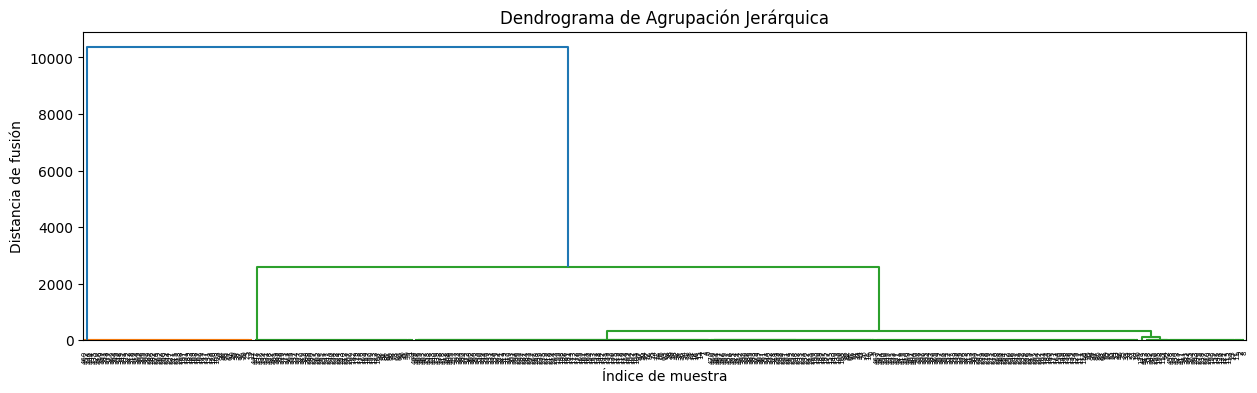

In [229]:
# Calcular la matriz de enlaces
X = df_train.values
Z = linkage(X, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(15, 4))
dendrogram(Z)
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia de fusión')
plt.title('Dendrograma de Agrupación Jerárquica')
plt.show()

Forma 2) Metodo del codo: calculamos la inercia para cada K y graficamos el resultado para buscar el codo

<ipython-input-230-ca4b3d496066>:9: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.

<ipython-input-230-ca4b3d496066>:9: ConvergenceWarning:

Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.



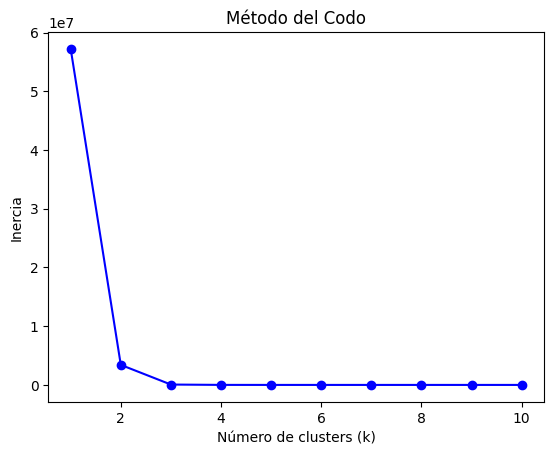

In [230]:
# Lista para almacenar los valores de inercia (suma de distancias cuadradas)
inercias = []

# Rango de valores de k para probar
k_values = range(1, 11)  

# Iterar sobre los valores de k y calcular la inercia para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(df_train)
    inercias.append(kmeans.inertia_)

# Graficar la curva de inercias en función de k
plt.plot(k_values, inercias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

En el grafico podemos ver que un numero optimo de K es 2 o 3

In [231]:
df_train.head()

eventId  processName_categ  parentProcessId
33665        4                9.0                1
39607      257                9.0                1
6704        41                9.0                1
74102     1005                9.0                1
39732        5                9.0                1

Vamos a entrenar un algortimo de kmeans con k=2

Puntuación del coeficiente de silueta: 0.9268231733821702


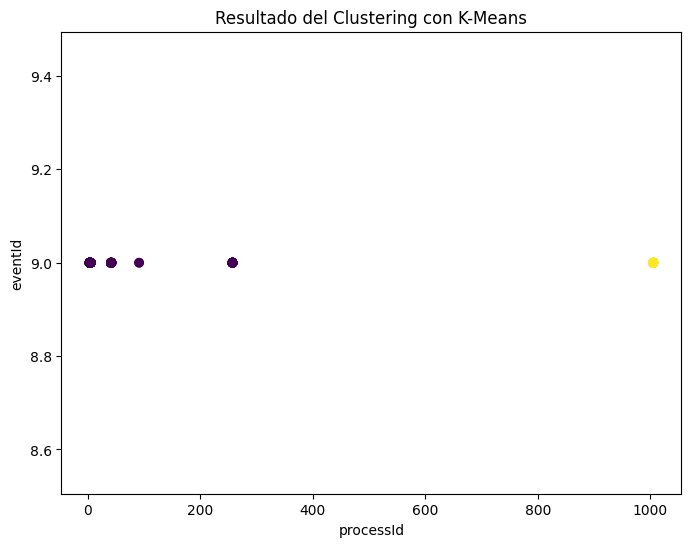

In [232]:
df_kmeans = df_train.copy()
k = 2  # Número de clusters

kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)

# Entrenar el modelo de KMeans
kmeans.fit(df_kmeans)

# Obtener las etiquetas de cluster asignadas a cada muestra
labels = kmeans.labels_

# Calcular la puntuación del coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir la puntuación del coeficiente de silueta
print(f'Puntuación del coeficiente de silueta: {silhouette_avg}')

# Agregar las etiquetas de cluster como una columna al DataFrame original
df_kmeans['cluster'] = labels

# Graficar los resultados en 2D
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_kmeans[var1], df_kmeans[var2], c=labels, cmap='viridis')
ax.set_title('Resultado del Clustering con K-Means')
ax.set_xlabel('processId')
ax.set_ylabel('eventId')
# plt.colorbar(scatter)
plt.show()

In [233]:
# Graficar el resultado en 3D
fig = px.scatter_3d(df_kmeans, x=var1, y=var2, z=var3, color='cluster',
                    color_continuous_scale='Viridis', opacity=0.8, size_max=5)
fig.update_layout(scene=dict(xaxis_title=var1, yaxis_title=var2, zaxis_title=var3))
fig.show()

In [234]:
df_kmeans.head()

eventId  processName_categ  parentProcessId  cluster
33665        4                9.0                1        0
39607      257                9.0                1        0
6704        41                9.0                1        0
74102     1005                9.0                1        1
39732        5                9.0                1        0

Como parte del procesamiento de los datos, habiamos normalizados los datos. Ahora necesitamos invertir la operacion para que los valores de los atributos tengan sentido.


In [235]:
columnas_desnormalizar = [var1, var2, var3]
df_kmeans[columnas_desnormalizar] = scaler.inverse_transform(df_kmeans[columnas_desnormalizar])
df_kmeans.head()

eventId  processName_categ  parentProcessId  cluster
33665    1583.349566               18.0              2.0        0
39607   89763.470733               18.0              2.0        0
6704    14479.256614               18.0              2.0        0
74102  350469.915922               18.0              2.0        1
39732    1931.887594               18.0              2.0        0

Podemos ver que el evento anomalo es el que se encuentra en el cluster=1

In [236]:
df_kmeans[df_kmeans['cluster']==1].head()

eventId  processName_categ  parentProcessId  cluster
74102  350469.915922               18.0              2.0        1
39769  350469.915922               18.0              2.0        1
39773  350469.915922               18.0              2.0        1
39724  350469.915922               18.0              2.0        1
26     350469.915922               18.0              2.0        1

Predecimos el cluster de los registros en el conjunto de testeo

In [237]:
df_kmeans_test = df_test.copy()
predicciones = kmeans.predict(df_kmeans_test)
df_kmeans_test['prediction'] = predicciones
df_kmeans_test

eventId  processName_categ  parentProcessId  prediction
74192        5                9.0                1           0
39766        5                9.0                1           0
74184     1005                9.0                1           1
45703       41                9.0                1           0
39685        5                9.0                1           0
...        ...                ...              ...         ...
74225      257                9.0                1           0
24198       41                9.0                1           0
48249        3                9.0                1           0
45757        4                9.0                1           0
45705        4                9.0                1           0

[118 rows x 4 columns]

Podemos ver que las categorias con prediccion=1 son los eventos anomalos para este usuario

#### Isolation Forest

Entrenamos el modelo con el mismo dataset que usamos en kmeans ya que para este modelo, tambien se requiere que las variables sean numericas

In [249]:
modelo = IsolationForest(n_estimators=100, contamination=0.05)

df_isolation = df_train.copy()
# Ajustar el modelo a los datos
modelo.fit(df_isolation)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.05)

In [250]:
# Predecir las anomalías en los datos
predicciones = modelo.predict(df_isolation)

# Las predicciones son -1 para anomalías y 1 para datos normales
cantidad_anomalias = (predicciones == -1).sum()
print('Cantidad de anomalias: ', cantidad_anomalias)

# También podemos obtener la puntuación de anomalía para cada punto de datos
puntuaciones_anomalia = modelo.decision_function(df_isolation)
df_isolation['puntuaciones_anomalia'] = puntuaciones_anomalia
df_isolation['predicciones'] = predicciones

df_isolation.head()

Cantidad de anomalias:  12


eventId  processName_categ  parentProcessId  puntuaciones_anomalia  \
33665        4                9.0                1               0.130962   
39607      257                9.0                1               0.041370   
6704        41                9.0                1               0.061725   
74102     1005                9.0                1               0.000000   
39732        5                9.0                1               0.151881   

       predicciones  
33665             1  
39607             1  
6704              1  
74102             1  
39732             1

Vamos ahora a predecir la clase con el conjunto de testeo

In [251]:
df_isolation_test = df_test.copy()
# Aplicar el modelo entrenado para predecir anomalías en los nuevos datos
predicciones_nuevos_datos = modelo.predict(df_isolation_test)
df_isolation_test['predicciones'] = predicciones_nuevos_datos
df_isolation_test

eventId  processName_categ  parentProcessId  predicciones
74192        5                9.0                1             1
39766        5                9.0                1             1
74184     1005                9.0                1             1
45703       41                9.0                1             1
39685        5                9.0                1             1
...        ...                ...              ...           ...
74225      257                9.0                1             1
24198       41                9.0                1             1
48249        3                9.0                1             1
45757        4                9.0                1             1
45705        4                9.0                1             1

[118 rows x 4 columns]

Podemos ver que los registros cuyas clases son -1, son los eventos considerados anomalos

In [252]:
df_isolation_test[df_isolation_test['predicciones']==-1]

eventId  processName_categ  parentProcessId  predicciones
74252       91                9.0                1            -1
74249       91                9.0                1            -1
6705        42                9.0                1            -1

Por lo tanto, para el usuario en cuestion, los eventos anomalos serian cuando el eventId es 91, el processName_categ = 9 y el parentProcessId = 1 y tambien cuando el eventId es 42, el processName_categ = 9 y el parentProcessId = 1

#### Con estadistica 

Vamos a tomar un ultimo approach al problema, esta vez con estadistica.

Consideremos el siguiente ejemplo de una anomalia: *Si el usuario de id 1000 solo genera eventos con proceso de tipo “ps” y de repente genera eventos con procesos “bash” debería ser considerado como anómalo. En cambio si el usuario 100 solo genera eventos con procesos bash no debe ser considerado como anómalo.*

Entonces, podemos ver la frecuencia de los procesos generados por cada usuario y etiquetar como anomalos los que tengan frecuencia muy baja. Para eso, graficamos un histograma para eventos y otro para procesosa

In [42]:
# Creamos un histograma de eventId

df_kmeans101[var1].unique()

fig = px.histogram(df_kmeans101, x=var1, nbins=len(df_kmeans101))
fig.show()

Vemos que hay algunos eventos que tienen alta frecuencia como el eventId=5 o eventId=1005. Sin embargo, hay otro como eventId=91 o eventId=42 que tiene muy baja frecuencia por lo que seria considerado anomalo. Como podemos ver, concuerda con lo obtenido en el modelo anterior en el que obtuvimos que los eventos anomalos serian cuando el eventId es 91, el processName_categ = 9 y el parentProcessId = 1 y tambien cuando el eventId es 42, el processName_categ = 9 y el parentProcessId = 1


In [46]:
# Creamos un histograma de processId

print(df_kmeans101[var2].unique())
fig = px.histogram(df_kmeans101, x=var3, nbins=len(df_kmeans101))
fig.show()

[9.]


Vemos que hay un solo procesId por lo que no vemos nada anomalo

#### Usuario 109

Eleccion de K con Agrupacion Jerarquica

In [ ]:
# Nos quedamos solo con las posibles variables para entrenar un modelo de kmeans

columns = ['processId', 'parentProcessId', 'eventId', 'argsNum', 'returnValue','userId'] #  'processName''',
df_kmeans = df_filtered[columns]
df_kmeans

processId  parentProcessId  eventId  argsNum  returnValue  userId
0             387                1       41        3           15     101
5             387                1        3        1            0     101
6             387                1     1005        4            0     101
7             387                1      257        4           15     101
8             387                1        5        2            0     101
...           ...              ...      ...      ...          ...     ...
377532       7790             7788      157        5            0     109
378273       7790             7788     1010        0            0     109
378329       7789             7787     1010        0            0     109
378396        383                1       41        3           15     100
378401        383                1        3        1            0     100

[4051 rows x 6 columns]

In [ ]:
df_kmeans101 = df_kmeans[df_kmeans['userId']==109]
df_kmeans101.drop(['userId'],axis=1, inplace=True)
df_kmeans101

<ipython-input-221-1daca1784f6f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



processId  parentProcessId  eventId  argsNum  returnValue
94057        7442             7432     1003        1            0
94058        7442             7432      106        1           -1
94059        7442             7432     1003        1            0
94060        7442             7432     1003        1            0
94061        7442             7432      105        1           -1
...           ...              ...      ...      ...          ...
377530       7790             7788     1003        1            0
377531       7790             7788      157        5            0
377532       7790             7788      157        5            0
378273       7790             7788     1010        0            0
378329       7789             7787     1010        0            0

[108 rows x 5 columns]

In [ ]:
# Eleccion de atributos 

columns = ['eventId', 'processId', 'parentProcessId',] #  'processName''',
df_kmeans101 = df_kmeans101[columns]
df_kmeans101

eventId  processId  parentProcessId
94057      1003       7442             7432
94058       106       7442             7432
94059      1003       7442             7432
94060      1003       7442             7432
94061       105       7442             7432
...         ...        ...              ...
377530     1003       7790             7788
377531      157       7790             7788
377532      157       7790             7788
378273     1010       7790             7788
378329     1010       7789             7787

[108 rows x 3 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizar los datos
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_kmeans101)
df_encoded_scaled = pd.DataFrame(df_encoded_scaled, columns=df_kmeans101.columns)
df_encoded_scaled

eventId  processId  parentProcessId
0    0.890493  -2.016951        -2.039410
1   -1.175298  -2.016951        -2.039410
2    0.890493  -2.016951        -2.039410
3    0.890493  -2.016951        -2.039410
4   -1.177601  -2.016951        -2.039410
..        ...        ...              ...
103  0.890493   0.855759         0.842614
104 -1.057845   0.855759         0.842614
105 -1.057845   0.855759         0.842614
106  0.906614   0.855759         0.842614
107  0.906614   0.847505         0.834519

[108 rows x 3 columns]

In [ ]:
# Dividimos en train y test 

df_train, df_test = train_test_split(df_encoded_scaled, test_size=0.2, random_state=42)

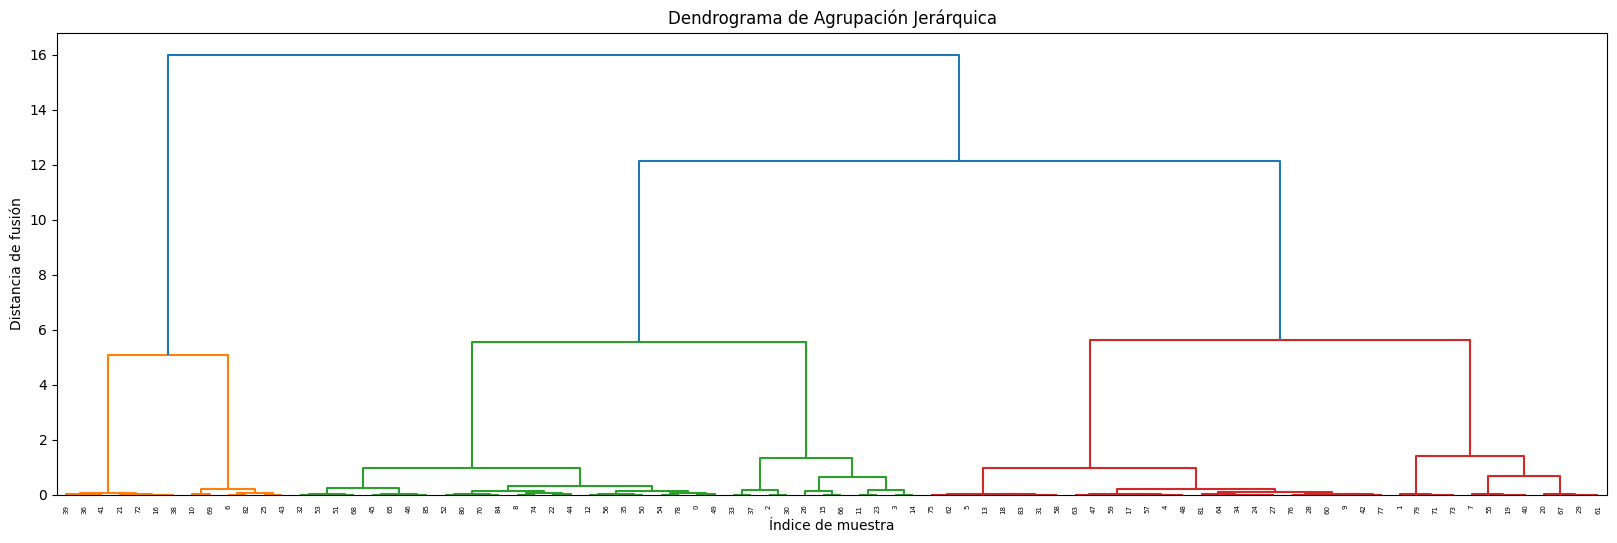

In [ ]:
# Calcular la matriz de enlaces
X = df_train.values
Z = linkage(X, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(20, 6))
dendrogram(Z)
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia de fusión')
plt.title('Dendrograma de Agrupación Jerárquica')
plt.show()


Podemos ver que algunos K optimos pueden ser k= 2 o 3 o 6

Ahora evaluamos la eleccion de K con el metodo del codo

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

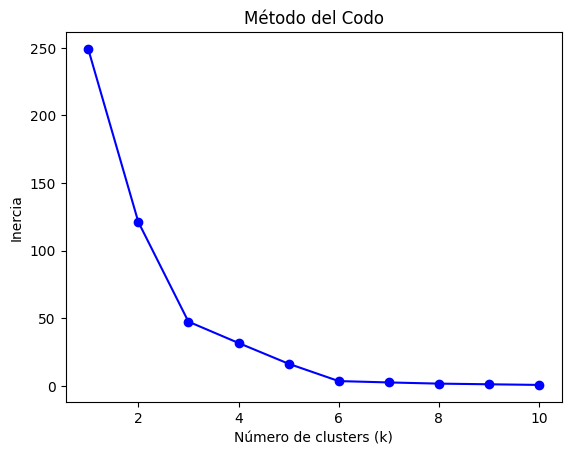

In [ ]:
X = df_train

# Lista para almacenar los valores de inercia (suma de distancias cuadradas)
inercias = []

# Rango de valores de k para probar
k_values = range(1, 11)  # Puedes ajustar el rango según tus necesidades

# Iterar sobre los valores de k y calcular la inercia para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inercias.append(kmeans.inertia_)

# Graficar la curva de inercias en función de k
plt.plot(k_values, inercias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

Del grafico del codo podemos ver que un numero optimo de K es 2 o 4. Ahora si, entrenamos dos modelo con k=2 y k=4

In [ ]:
df_train.head()

eventId  processId  parentProcessId
64 -1.175298   0.641132         0.640225
26  0.906614  -0.580596        -0.557920
22 -1.177601  -0.580596        -0.557920
31 -1.177601  -0.266909        -0.250288
47  0.890493   0.599857         0.599747

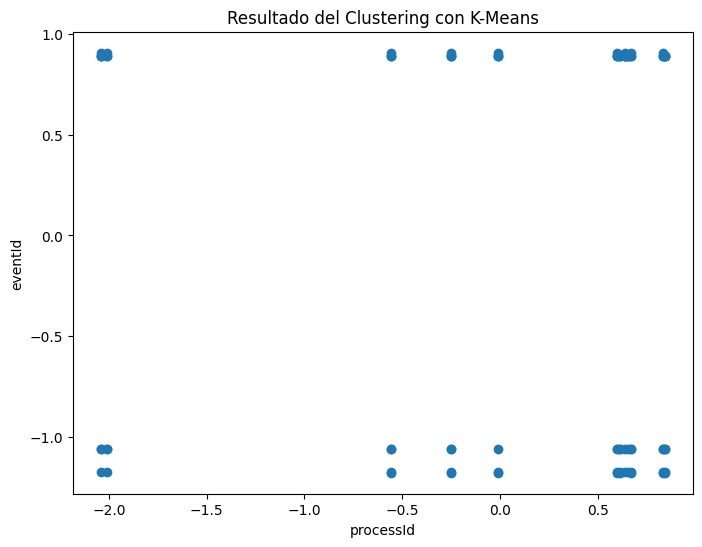

In [ ]:
# Graficar los resultados
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_train['parentProcessId'], df_train['eventId'])
ax.set_title('Resultado del Clustering con K-Means')
ax.set_xlabel('processId')
ax.set_ylabel('eventId')
# plt.colorbar(scatter)
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Crear gráfico en 3D
fig = px.scatter_3d(df_train, x='processId', y='parentProcessId', z='eventId')
fig.update_layout(title='Gráfico en 3D de DataFrame')
fig.show()


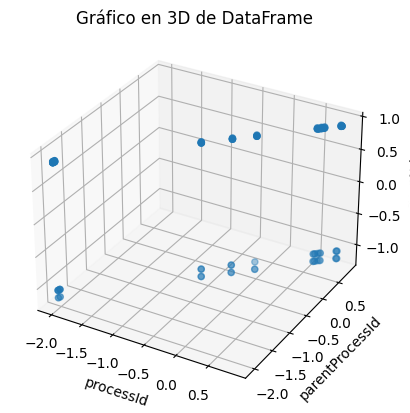

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos en 3D
ax.scatter(df_train['processId'], df_train['parentProcessId'], df_train['eventId'])
ax.set_xlabel('processId')
ax.set_ylabel('parentProcessId')
ax.set_zlabel('eventId')
ax.set_title('Gráfico en 3D de DataFrame')

# Mostrar el gráfico
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Puntuación del coeficiente de silueta: 0.5908756768133834


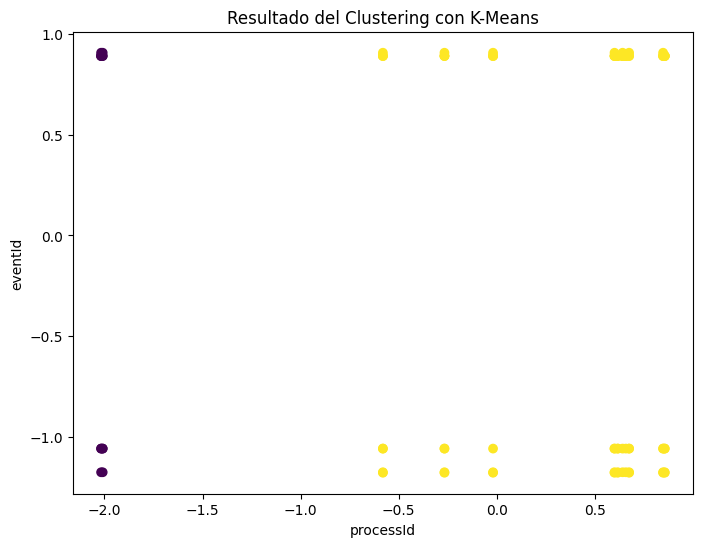

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Seleccionar las columnas que deseas utilizar para el clustering
X = df_train # Reemplaza con los nombres de tus columnas

# Crear un objeto de KMeans con el número de clusters deseado
k = 2  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=0)

# Entrenar el modelo de KMeans
kmeans.fit(X)

# Obtener las etiquetas de cluster asignadas a cada muestra
labels = kmeans.labels_

# Calcular la puntuación del coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir la puntuación del coeficiente de silueta
print(f'Puntuación del coeficiente de silueta: {silhouette_avg}')

# Agregar las etiquetas de cluster como una columna al DataFrame original
df_train['cluster'] = labels

# Graficar los resultados
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_train['processId'], df_train['eventId'], c=labels, cmap='viridis')
ax.set_title('Resultado del Clustering con K-Means')
ax.set_xlabel('processId')
ax.set_ylabel('eventId')
#plt.colorbar(scatter)
plt.show()

In [ ]:
df_train

eventId  processId  parentProcessId  cluster
64  -1.175298   0.641132         0.640225        1
26   0.906614  -0.580596        -0.557920        1
22  -1.177601  -0.580596        -0.557920        1
31  -1.177601  -0.266909        -0.250288        1
47   0.890493   0.599857         0.599747        1
..        ...        ...              ...      ...
71   0.906614   0.641132         0.640225        1
14  -1.057845  -2.008696        -2.007028        0
92   0.890493   0.847505         0.834519        1
51  -1.057845   0.599857         0.599747        1
102 -1.177601   0.855759         0.842614        1

[86 rows x 4 columns]

In [ ]:
# Denormalizar las columnas A, B, C del DataFrame
df_denormalized = pd.DataFrame(scaler.inverse_transform(df_train.drop), columns=df_train.columns)
df_denormalized

ValueError: ignored

In [ ]:
# Denormalizamos
df_denormalized = scaler.inverse_transform(np.array(df_train))
df_denormalized

ValueError: ignored

#### Usuario 100

Eleccion de K con Agrupacion Jerarquica

In [ ]:
df_kmeans101 = df_kmeans[df_kmeans['userId']==100]
df_kmeans101.drop(['userId'],axis=1, inplace=True)
df_kmeans101

<ipython-input-75-96ceee440eb0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



processId  parentProcessId  eventId
4171          383                1       41
4176          383                1        3
5377          383                1       41
5382          383                1        3
6585          383                1       41
...           ...              ...      ...
374382        383                1        3
375519        383                1       41
375524        383                1        3
378396        383                1       41
378401        383                1        3

[976 rows x 3 columns]

In [ ]:
# VALIDACION CRUZADA

In [ ]:
# Dividimos en train y test 

df_train, df_test = train_test_split(df_kmeans101, test_size=0.2, random_state=42)

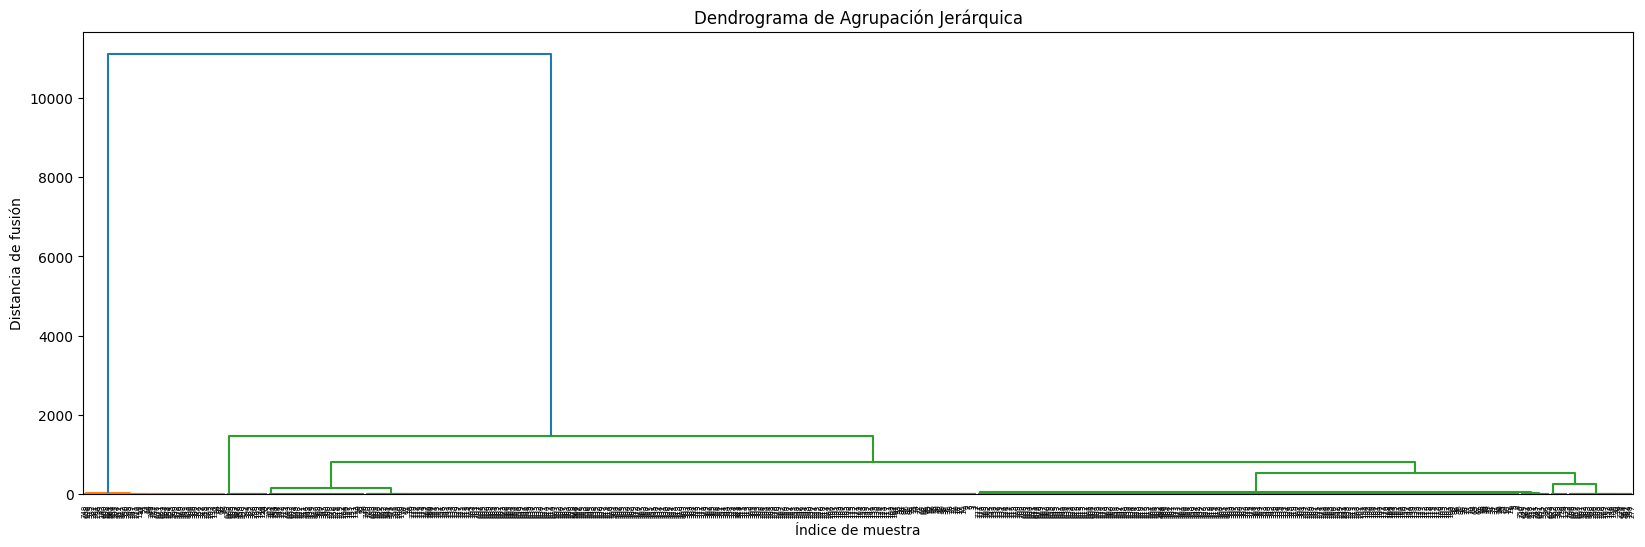

In [ ]:
# Calcular la matriz de enlaces
X = df_train.values
Z = linkage(X, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(20, 6))
dendrogram(Z)
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia de fusión')
plt.title('Dendrograma de Agrupación Jerárquica')
plt.show()


Podemos ver que algunos K optimos pueden ser k= 2 o 3 o 4

Ahora evaluamos la eleccion de K con el metodo del codo

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

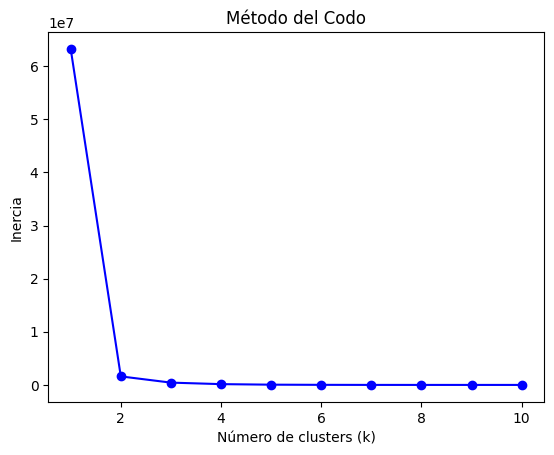

In [ ]:
X = df_train

# Lista para almacenar los valores de inercia (suma de distancias cuadradas)
inercias = []

# Rango de valores de k para probar
k_values = range(1, 11)  # Puedes ajustar el rango según tus necesidades

# Iterar sobre los valores de k y calcular la inercia para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inercias.append(kmeans.inertia_)

# Graficar la curva de inercias en función de k
plt.plot(k_values, inercias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

Del grafico del codo podemos ver que un numero optimo de K es 2 . Ahora si, entrenamos el modelo con k=2 

In [ ]:
df_train.head()

processId  parentProcessId  eventId
261601        383                1       41
248408        383                1        3
26510         383                1        3
24209         383                1        3
339894        383                1       41

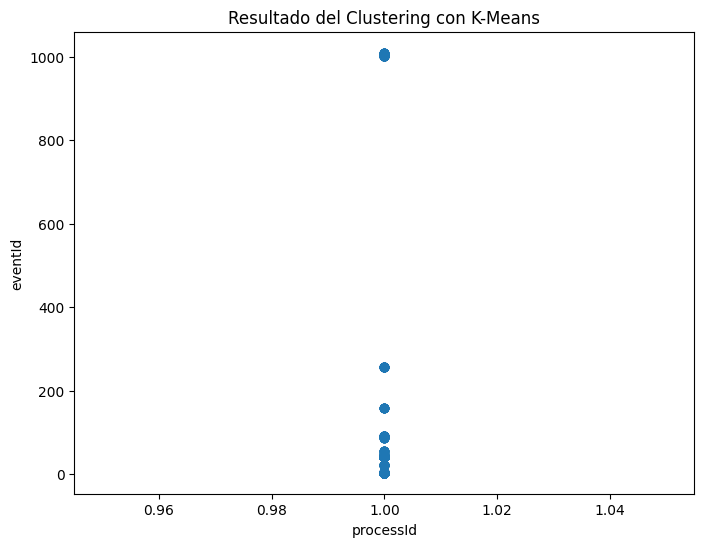

In [ ]:
# Graficar los resultados
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_train['parentProcessId'], df_train['eventId'])
ax.set_title('Resultado del Clustering con K-Means')
ax.set_xlabel('processId')
ax.set_ylabel('eventId')
# plt.colorbar(scatter)
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Crear gráfico en 3D
fig = px.scatter_3d(df_train, x='processId', y='parentProcessId', z='eventId')
fig.update_layout(title='Gráfico en 3D de DataFrame')
fig.show()


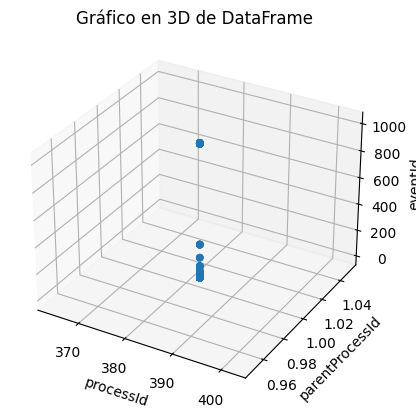

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos en 3D
ax.scatter(df_train['processId'], df_train['parentProcessId'], df_train['eventId'])
ax.set_xlabel('processId')
ax.set_ylabel('parentProcessId')
ax.set_zlabel('eventId')
ax.set_title('Gráfico en 3D de DataFrame')

# Mostrar el gráfico
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Puntuación del coeficiente de silueta: 0.9619086871738375


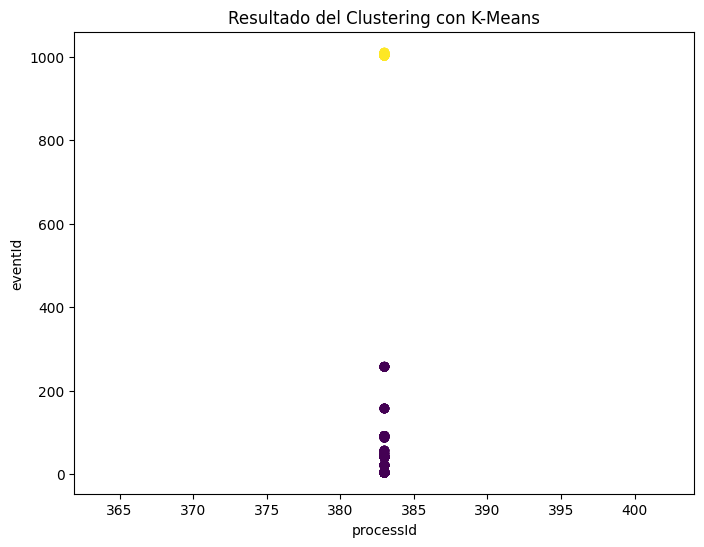

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Seleccionar las columnas que deseas utilizar para el clustering
X = df_train # Reemplaza con los nombres de tus columnas

# Crear un objeto de KMeans con el número de clusters deseado
k = 2  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=0)

# Entrenar el modelo de KMeans
kmeans.fit(X)

# Obtener las etiquetas de cluster asignadas a cada muestra
labels = kmeans.labels_

# Calcular la puntuación del coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir la puntuación del coeficiente de silueta
print(f'Puntuación del coeficiente de silueta: {silhouette_avg}')

# Agregar las etiquetas de cluster como una columna al DataFrame original
df_train['cluster'] = labels

# Graficar los resultados
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_train['processId'], df_train['eventId'], c=labels, cmap='viridis')
ax.set_title('Resultado del Clustering con K-Means')
ax.set_xlabel('processId')
ax.set_ylabel('eventId')
#plt.colorbar(scatter)
plt.show()

#### Usuario 1000

Eleccion de K con Agrupacion Jerarquica

In [ ]:
df_kmeans101 = df_kmeans[df_kmeans['userId']==1000]
df_kmeans101.drop(['userId'],axis=1, inplace=True)
df_kmeans101

<ipython-input-85-760938298f4e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



processId  parentProcessId  eventId
61         7238             1075        3
62         7238             1075        3
63         1047              940        3
64         1075             1047     1010
65         7238             1075     1010
...         ...              ...      ...
1466        725                1        3
1467        725                1        3
1468        725                1        3
1470        725                1     1010
1565        726                1     1010

[568 rows x 3 columns]

In [ ]:
# VALIDACION CRUZADA

In [ ]:
# Dividimos en train y test 

df_train, df_test = train_test_split(df_kmeans101, test_size=0.2, random_state=42)

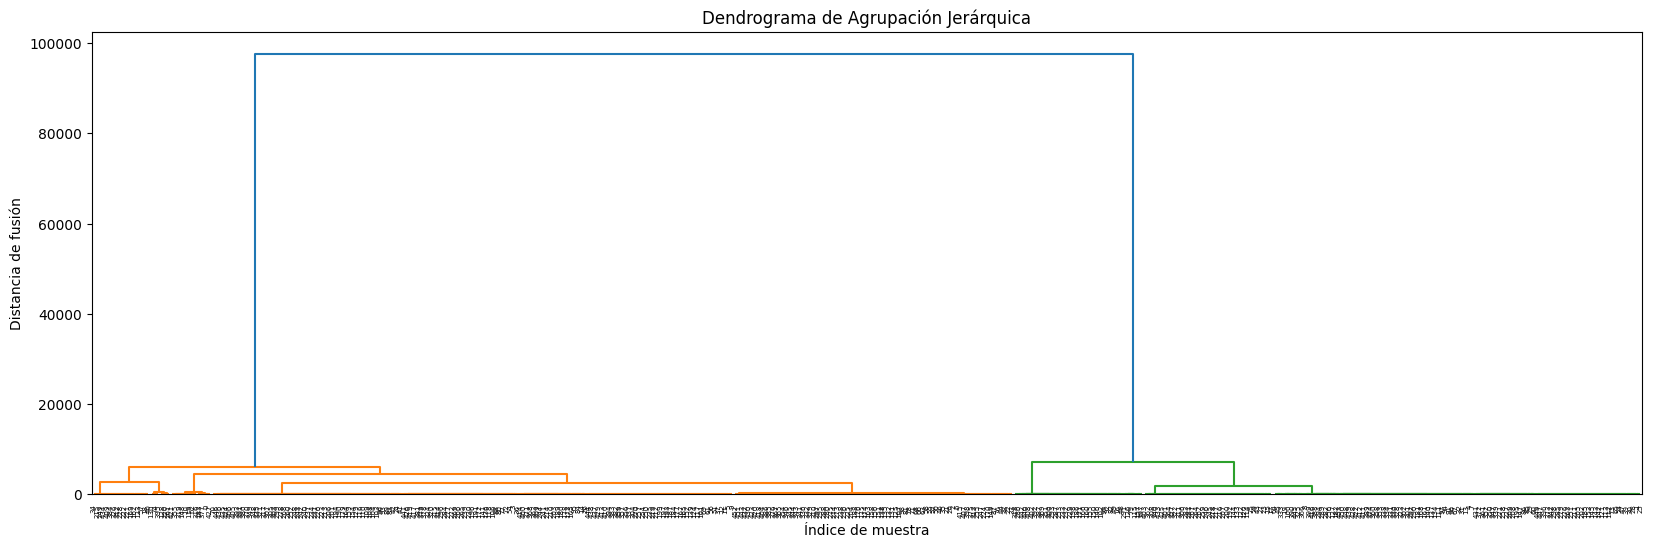

In [ ]:
# Calcular la matriz de enlaces
X = df_train.values
Z = linkage(X, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(20, 6))
dendrogram(Z)
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia de fusión')
plt.title('Dendrograma de Agrupación Jerárquica')
plt.show()


Podemos ver que algunos K optimos pueden ser k= 2 o 3 o 4

Ahora evaluamos la eleccion de K con el metodo del codo

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

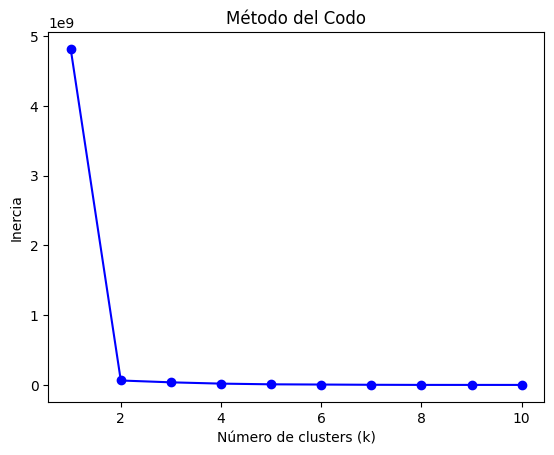

In [ ]:
X = df_train

# Lista para almacenar los valores de inercia (suma de distancias cuadradas)
inercias = []

# Rango de valores de k para probar
k_values = range(1, 11)  # Puedes ajustar el rango según tus necesidades

# Iterar sobre los valores de k y calcular la inercia para cada k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inercias.append(kmeans.inertia_)

# Graficar la curva de inercias en función de k
plt.plot(k_values, inercias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

Del grafico del codo podemos ver que un numero optimo de K es 2 . Ahora si, entrenamos el modelo con k=2 

In [ ]:
df_train.head()

processId  parentProcessId  eventId
540         911              838        3
171        7260             1047        5
1158        725                1      257
1216        725                1        3
116        7260             1047        3

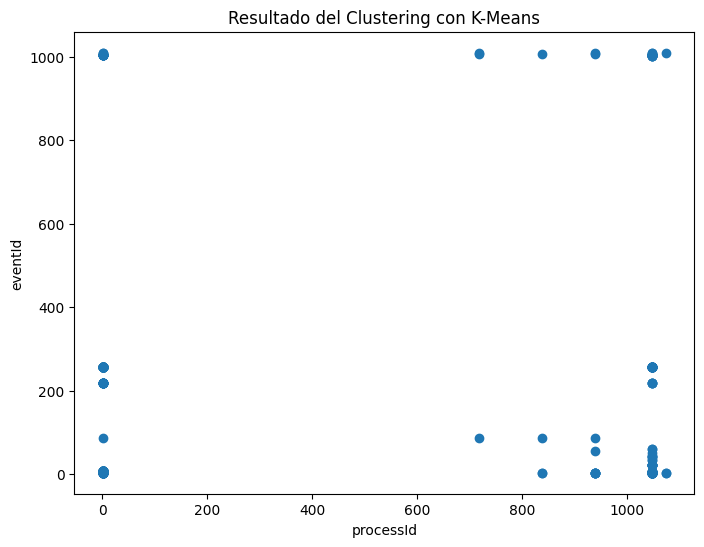

In [ ]:
# Graficar los resultados
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_train['parentProcessId'], df_train['eventId'])
ax.set_title('Resultado del Clustering con K-Means')
ax.set_xlabel('processId')
ax.set_ylabel('eventId')
# plt.colorbar(scatter)
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Crear gráfico en 3D
fig = px.scatter_3d(df_train, x='processId', y='parentProcessId', z='eventId')
fig.update_layout(title='Gráfico en 3D de DataFrame')
fig.show()


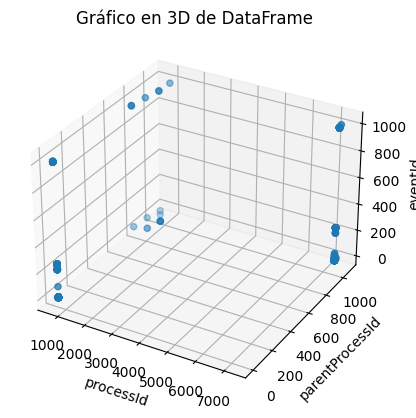

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Crear una figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos en 3D
ax.scatter(df_train['processId'], df_train['parentProcessId'], df_train['eventId'])
ax.set_xlabel('processId')
ax.set_ylabel('parentProcessId')
ax.set_zlabel('eventId')
ax.set_title('Gráfico en 3D de DataFrame')

# Mostrar el gráfico
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Puntuación del coeficiente de silueta: 0.9480508348735653


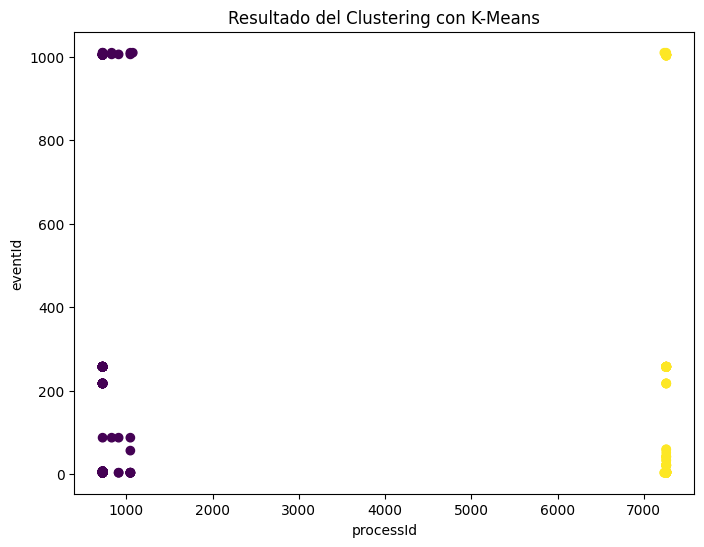

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Seleccionar las columnas que deseas utilizar para el clustering
X = df_train # Reemplaza con los nombres de tus columnas

# Crear un objeto de KMeans con el número de clusters deseado
k = 2  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=0)

# Entrenar el modelo de KMeans
kmeans.fit(X)

# Obtener las etiquetas de cluster asignadas a cada muestra
labels = kmeans.labels_

# Calcular la puntuación del coeficiente de silueta
silhouette_avg = silhouette_score(X, labels)

# Imprimir la puntuación del coeficiente de silueta
print(f'Puntuación del coeficiente de silueta: {silhouette_avg}')

# Agregar las etiquetas de cluster como una columna al DataFrame original
df_train['cluster'] = labels

# Graficar los resultados
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_train['processId'], df_train['eventId'], c=labels, cmap='viridis')
ax.set_title('Resultado del Clustering con K-Means')
ax.set_xlabel('processId')
ax.set_ylabel('eventId')
#plt.colorbar(scatter)
plt.show()